In [1]:
from scipy.ndimage import filters
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def compute_harris_response(im,sigma=3):
    #计算导数
    imx = np.zeros(im.shape)
    filters.gaussian_filter(im,(sigma,sigma),(0,1),imx)
    imy = np.zeros(im.shape)
    filters.gaussian_filter(im,(sigma,sigma),(1,0),imy)
    
    #计算Harris矩阵的分量
    Wxx = filters.gaussian_filter(imx*imx,sigma)
    Wxy = filters.gaussian_filter(imx*imy,sigma)
    Wyy = filters.gaussian_filter(imy*imy,sigma)
    #print(imx.shape)
    #print(imy.shape)
    #print(Wxx.shape)
    #print(Wxx)
    
    #计算特征值?行列式和迹
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    
    return Wdet/Wtr

In [3]:
def get_harris_points(harrisim,min_dist=10,threshold=0.1):
    """从一幅Harris响应图像中返回角点。min_dist为分割角点和图像边界的最小像素数目"""
    
    #寻找高于阈值的候选角点
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    #print(harrisim_t)
    
    #得到候选点的坐标
    coords = np.array(harrisim_t.nonzero()).T
    #print('coords:')
    #print(coords)
    #print('\ncoords.T')
    #print(coords.T)
    
    #以及它们的Harris响应值
    candidate_values = [harrisim[c[0],c[1]] for c in coords]
    #print(candidate_values)
    
    #对候选点按照Harris响应值进行排序2
    index = np.argsort(candidate_values)
    #print('\nindex:')
    #print(index)
    
    #将可行点的位置保存在数组中
    allowed_locations = np.zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    #print('\nallowed_locations:')
    #print(np.array(allowed_locations.nonzero()).T)
    
    #按照min_distance原则，选择最佳的Harris点
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist),(coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0
    
    return filtered_coords

In [4]:
def plot_harris_points(image,filtered_coords):
    
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'*')
    #plt.axis('off')
    plt.show()

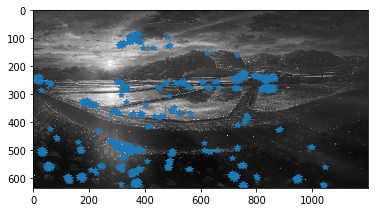

In [5]:
im = np.array(Image.open('test.jpg').convert('L'))
#print(im.shape)
harrisim = compute_harris_response(im)
#print('\n harrisim.shape:')
#print(harrisim.shape)
filtered_coords = get_harris_points(harrisim,6,0.1)
plot_harris_points(im,filtered_coords)

In [6]:
def get_descriptors(image,filtered_coords,wid = 5):
    """对于每个返回的点，返回点周围2*wid+1个像素的值（min_distance > wid）"""
    
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1,coords[1]-wid:coords[1]+wid+1].flatten()    #.flatten()进行降维，行优先
        desc.append(patch)
    
    return desc

In [7]:
def match(desc1,desc2,threshold = 0.5):
    """对于第一幅图像中的每个角点描述子，使用归一化互相关，选取它在第二幅图像中的匹配角点"""
    
    n = len(desc1[0])
    
    #点对的距离
    d = -np.ones((len(desc1),len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - np.mean(desc1[i]))/np.std(desc1[i])
            d2 = (desc2[j] - np.mean(desc2[j]))/np.std(desc2[j])
            ncc_value = sum(d1*d2)/(n-1)
            if ncc_value > threshold:
                d[i,j] = ncc_value
    
    ndx = np.argsort(-d)
    matchscores = ndx[:,0]
    
    return matchscores

In [8]:
def match_twosided(desc1,desc2,threshold = 0.5):
    """两边对称版本的match()"""
    
    matches_12 = match(desc1,desc2,threshold)
    matches_21 = match(desc2,desc1,threshold)
    
    ndx_12  = np.where(matches_12 >= 0)[0]
    
    #去除非对称的匹配
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
            
    return matches_12

In [9]:
def appendimages(im1,im2):
    """返回将两幅图像并排拼接成的一幅新图像"""
    
    #选取具有最少行数的图像，然后填充足够的空行
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = np.concatenate((im1,np.zeros((rows2-rows1,im1.shape[1]))),axis = 0)
    elif rows1 > rows2:
        im2 = np.concatenate((im2,np.zeros((rows1-rows2,im2.shape[1]))),axis = 0)
        
    return np.concatenate((im1,im2),axis=1)

In [10]:
def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """显示一幅带有连接匹配之间连线的图片
       输入：im1,im2（数组图像），locs1，locs2（特征位置），matchscores（match()的输出），
       show_below（如果图像应该显示在匹配的下方）"""
    
    im3 = appendimages(im1,im2)

    if show_below:
        im3 = np.vstack((im3,im3))
    
    plt.imshow(im3)
    
    cols1 = im1.shape[1]
    
    temp = []
    
    for i,m in enumerate(matchscores):
        if m > 0:
            plt.plot([locs1[i][1],locs2[m][1]+cols1],[locs1[i][0],locs2[m][0]],'c')
    
    plt.axis('off')

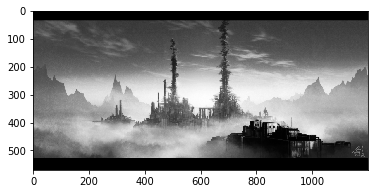

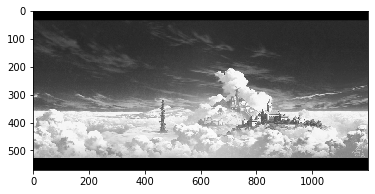

start matching
matching end


In [11]:
im1 = np.array(Image.open('im1.jpg').convert('L'))
plt.imshow(im1)
plt.show()
im2 = np.array(Image.open('im2.jpg').convert('L'))
plt.imshow(im2)
plt.show()

wid = 5

harrisim = compute_harris_response(im1,5)
filtered_coords1 = get_harris_points(harrisim,wid+1)
#print(np.array(filtered_coords1).shape)
d1 = get_descriptors(im1,filtered_coords1,wid)

harrisim = compute_harris_response(im2,5)
filtered_coords2 = get_harris_points(harrisim,wid+1)
d2 = get_descriptors(im2,filtered_coords2,wid)

print('start matching')
matches = match_twosided(d1,d2)
print('matching end')


In [16]:
print(np.array(filtered_coords1).shape)
print(np.array(d1).shape)

(542, 2)
(542, 121)


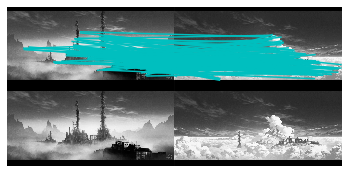

In [15]:

plt.figure()
plt.gray()
plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches)
#im = appendimages(im1,im2)
#plt.imshow(im)
plt.show()

In [19]:
print(np.array(filtered_coords1).shape)
print(matches.shape)
t = np.array([1,2,3,5])
print(t.shape)

(542, 2)
(542,)
(4,)


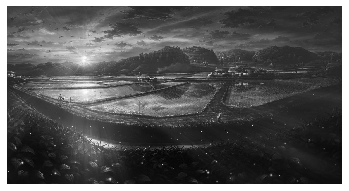

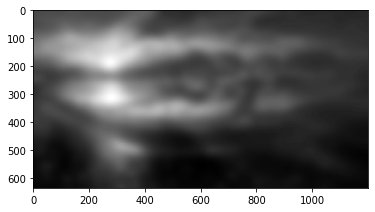

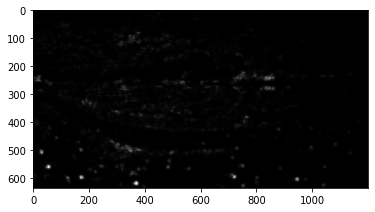

In [11]:
im = np.array(Image.open('test.jpg').convert('L'))
#print(im.shape)
plt.gray()
plt.axis('off')
plt.imshow(im)
plt.show()

im_noisy = filters.gaussian_filter(im,16)

plt.imshow(im_noisy,cmap='gray')
plt.show()


res = compute_harris_response(im)
#print(res)
plt.imshow(res,cmap = 'gray')
plt.show()

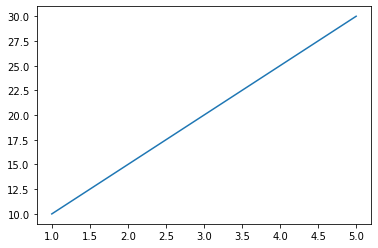

In [13]:
x = np.array([1,3,5])
y = np.array([10,20,30])
plt.plot(x,y)
plt.show()

In [ ]:
a = np.zeros([3,5])
print(a.shape)
#min_dist = 1
a[2,4] = 1
#a[min_dist:-min_dist,min_dist:-min_dist] = 1
print(a)